# experimenting w xoak
see https://xoak.readthedocs.io/en/latest/examples/introduction.html


this doesn't work: "ValueError: Haversine distance only valid in 2 dimensions" - can't do in time
maybe a diff function?????

In [1]:
import xarray as xr
import numpy as np
import xoak
import matplotlib.pyplot as plt


In [2]:
shape = (100, 100)
lat = np.random.uniform(-90, 90, size=shape)
lon = np.random.uniform(-180, 180, size=shape)

field = lat + lon

In [4]:
ds_mesh = xr.Dataset(
    coords={'lat': (('x', 'y'), lat), 'lon': (('x', 'y'), lon)},
    data_vars={'field': (('x', 'y'), field)},
)

ds_mesh

<xarray.Dataset>
Dimensions:  (x: 100, y: 100)
Coordinates:
    lat      (x, y) float64 -1.596 -59.91 88.86 -86.46 ... 8.813 45.26 -47.66
    lon      (x, y) float64 100.2 76.98 -177.1 -44.6 ... 34.44 -42.47 -121.9
Dimensions without coordinates: x, y
Data variables:
    field    (x, y) float64 98.63 17.07 -88.2 -131.1 ... 43.26 2.784 -169.5

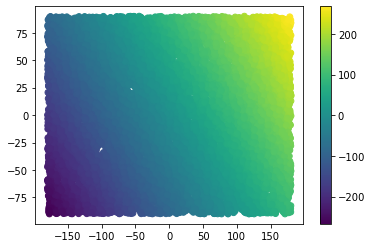

In [5]:
plt.scatter(ds_mesh.lon, ds_mesh.lat, c=ds_mesh.field)
plt.colorbar()
plt.show()

In [6]:
ds_mesh.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')


In [7]:
# ex:
ds_trajectory = xr.Dataset({
    'latitude': ('trajectory', np.linspace(-10, 40, 30)),
    'longitude': ('trajectory', np.linspace(-150, 150, 30))
})

# my own:
ds_trajectory = xr.Dataset({
    'latitude': ('trajectory', [-25, -25, 0, 0, 25]),
    'longitude': ('trajectory', [-100, -50, -50, 0, 0])
})




ds_trajectory

<xarray.Dataset>
Dimensions:    (trajectory: 5)
Dimensions without coordinates: trajectory
Data variables:
    latitude   (trajectory) int64 -25 -25 0 0 25
    longitude  (trajectory) int64 -100 -50 -50 0 0

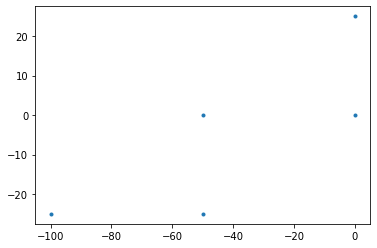

In [8]:
plt.plot(ds_trajectory.longitude, ds_trajectory.latitude,'.')
plt.show()

In [9]:
ds_selection = ds_mesh.xoak.sel(
    lat=ds_trajectory.latitude,
    lon=ds_trajectory.longitude
)

ds_selection

<xarray.Dataset>
Dimensions:  (trajectory: 5)
Coordinates:
    lat      (trajectory) float64 -25.22 -26.12 -1.917 0.3551 25.81
    lon      (trajectory) float64 -100.5 -51.13 -50.21 1.511 -1.04
Dimensions without coordinates: trajectory
Data variables:
    field    (trajectory) float64 -125.7 -77.26 -52.13 1.866 24.77

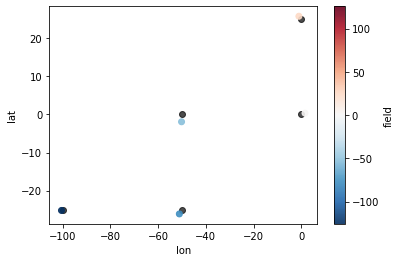

In [10]:
ds_trajectory.plot.scatter(x='longitude', y='latitude', c='k', alpha=0.7);
ds_selection.plot.scatter(x='lon', y='lat', hue='field', alpha=0.9);



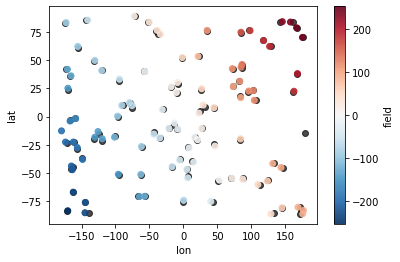

In [11]:
ds_mesh2 = xr.Dataset({
    'latitude': (('x', 'y'), np.random.uniform(-90, 90, size=(10, 10))),
    'longitude': (('x', 'y'), np.random.uniform(-180, 180, size=(10, 10)))
})

ds_selection = ds_mesh.xoak.sel(
    lat=ds_mesh2.latitude,
    lon=ds_mesh2.longitude
)

ds_selection

ds_mesh2.plot.scatter(x='longitude', y='latitude', c='k', alpha=0.7);
ds_selection.plot.scatter(x='lon', y='lat', hue='field', alpha=0.9);

In [12]:
# large data
# https://xoak.readthedocs.io/en/latest/examples/dask_support.html
import dask
import dask.array as da

In [13]:
shape = (500, 500)
chunk_shape = (250, 250)

lat = da.random.uniform(-90, 90, size=shape, chunks=chunk_shape)
lon = da.random.uniform(-180, 180, size=shape, chunks=chunk_shape)

field = lat + lon

ds_mesh = xr.Dataset(
    coords={'lat': (('x', 'y'), lat), 'lon': (('x', 'y'), lon)},
    data_vars={'field': (('x', 'y'), field)},
)

ds_mesh

<xarray.Dataset>
Dimensions:  (x: 500, y: 500)
Coordinates:
    lat      (x, y) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    lon      (x, y) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    field    (x, y) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>

In [14]:
ds_mesh.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')

# here returns a list of BallTree objects, one for each chunk
ds_mesh.xoak.index

In [15]:
shape = (100, 10)
chunk_shape = (50, 10)

ds_data = xr.Dataset({
    'lat': (('y', 'x'), da.random.uniform(-90, 90, size=shape, chunks=chunk_shape)),
    'lon': (('y', 'x'), da.random.uniform(-180, 180, size=shape, chunks=chunk_shape))
})

ds_data


<xarray.Dataset>
Dimensions:  (y: 100, x: 10)
Dimensions without coordinates: y, x
Data variables:
    lat      (y, x) float64 dask.array<chunksize=(50, 10), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(50, 10), meta=np.ndarray>

In [48]:
from dask.diagnostics import ProgressBar

with ProgressBar(), dask.config.set(scheduler='processes'):
    ds_selection = ds_mesh.xoak.sel(lat=ds_data.lat, lon=ds_data.lon)

ds_selection



[########################################] | 100% Completed |  2.5s


<xarray.Dataset>
Dimensions:  (y: 100, x: 10)
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    field    (y, x) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>

In [165]:
ds

<xarray.Dataset>
Dimensions:   (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84, k_l: 84,
               k_p1: 85, time: 48, nb: 2)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 345.0 346.0 347.0 348.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83 84
  * nb        (nb) int32 0 1
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-02T23:00:00
Data variables: (12/35)
    XC        (time, j, i) float32 dask.array<chunksize=(24, 150, 192), meta=np.ndarray>
    YC        (time, j, i) float32 dask.array<chunksize=(24, 150, 192), meta=np.ndarray>
    DXV       (time, j, i) float32 dask.array<chunksize=(24, 150, 192), meta=np.ndarray>
    DYU       (time, j, i) float32 dask.array<chunksize=(24, 150, 192), meta=np.ndarray>
    Depth     (time, j, i) float32 dask.array<chunksize=(24, 150, 192), meta=np.ndarray>
    AngleSN   (time, j, i) float32 dask.array<chunksize=(24, 150, 192), meta=np.ndarray>
    ...        ...
    oceTAUY   (time, j_g, i) float64 dask.array<chunksize=(12, 349, 192), meta=np.ndarray>
    Theta     (time, k, j, i) float64 dask.array<chunksize=(12, 84, 150, 192), meta=np.ndarray>
    Salt      (time, k, j, i) float64 dask.array<chunksize=(12, 84, 150, 192), meta=np.ndarray>
    U         (time, k, j, i_g) float32 dask.array<chunksize=(12, 84, 150, 192), meta=np.ndarray>
    V         (time, k, j_g, i) float64 dask.array<chunksize=(12, 84, 349, 192), meta=np.ndarray>
    W         (time, k_l, j, i) float64 dask.array<chunksize=(12, 84, 150, 192), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

# example with llc4320 dataset!!

In [2]:
target_files = ['/data1/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120101.nc',
 '/data1/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120102.nc']

tchunk = 12 
xchunk = 200
ychunk = 150
ds = xr.open_mfdataset(target_files, parallel=True, 
                      chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})

# start with 2-d subset
dsub = ds.Theta.to_dataset()
dsub = ds.Theta.isel(k=0, time=0).to_dataset()
dsub = dsub.reset_coords({'k', 'time'}, drop=True)
dsub


<xarray.Dataset>
Dimensions:  (i: 192, j: 349)
Coordinates:
  * i        (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * j        (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0
Data variables:
    Theta    (j, i) float64 dask.array<chunksize=(150, 192), meta=np.ndarray>

In [4]:
# can't use the original dataset.... try building a dataset from scratch
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)
    
dsx = xr.Dataset(
    coords={'X': (('i', 'j'), X.values), 'Y': (('i', 'j'), Y.values)},
    data_vars={'Theta': (('i', 'j'), dsub['Theta'].values)},
)
dsx

<xarray.Dataset>
Dimensions:  (i: 349, j: 192)
Coordinates:
    X        (i, j) float32 150.3 150.3 150.3 150.4 ... 154.2 154.2 154.3 154.3
    Y        (i, j) float32 -56.99 -56.99 -56.99 -56.99 ... -53.01 -53.01 -53.01
Dimensions without coordinates: i, j
Data variables:
    Theta    (i, j) float64 1.959 1.962 1.96 1.949 ... 7.759 7.686 7.548 7.359

In [5]:
# xoak set index:
dsx.xoak.set_index(['X', 'Y'], 'sklearn_geo_balltree')

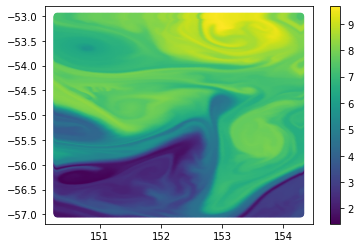

In [6]:
plt.scatter(dsx.X, dsx.Y, c=dsx.Theta)
plt.colorbar()
plt.show()

In [7]:
# trajectory file
tds = xr.open_dataset('../data/survey_trajectory_ACC_SMST_glider.nc')

xs = tds.xwaypoints.isel(points=[0,1]).values
xs = np.linspace(xs[0],xs[1],20)
ys = tds.ywaypoints.isel(points=[0,1]).values
ys = np.linspace(ys[0],ys[1],20)

traj = xr.Dataset({
    'X': ('points', xs),
    'Y': ('points',ys)
})

In [8]:
# apply xoak magic:
ds_subsamp = dsx.xoak.sel(
    X=traj.X,
    Y=traj.Y
)

ds_subsamp

<xarray.Dataset>
Dimensions:  (points: 20)
Coordinates:
    X        (points) float32 151.7 151.8 151.9 151.9 ... 152.8 152.8 152.9
    Y        (points) float32 -55.0 -55.0 -55.0 -55.0 ... -55.0 -55.0 -55.0
Dimensions without coordinates: points
Data variables:
    Theta    (points) float64 7.796 7.785 7.713 7.612 ... 5.648 4.719 4.928

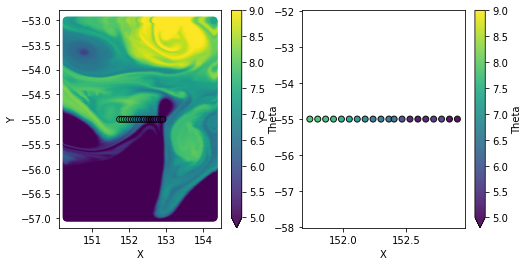

In [9]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
vmin=5
vmax=9

axs[0].scatter(dsx.X, dsx.Y, c=dsx.Theta, vmin=vmin, vmax=vmax)
# axs[0].colorbar()
ds_subsamp.plot.scatter(ax=axs[0], x='X', y='Y', hue='Theta', alpha=0.9, vmin=vmin, vmax=vmax, edgecolors='black');


ds_subsamp.plot.scatter(ax=axs[1], x='X', y='Y', hue='Theta', alpha=0.9, vmin=vmin, vmax=vmax, edgecolors='black');


In [13]:
# now try 3d
# time gets messed up, so skip that for now, do x y z

dsub = ds.Theta.to_dataset()
# # dsub = ds.Theta.isel(k=0).to_dataset()
# dsub = dsub.reset_coords({'k'}, drop=True)
dsub = ds.Theta.isel(time=0).to_dataset()
dsub = dsub.reset_coords({'time'}, drop=True)


X = ds.XC.broadcast_like(ds.Z).isel(time=0)
Y = ds.YC.broadcast_like(ds.Z).isel(time=0)
# T = ds.time
Z = ds.Z.broadcast_like(X).isel(time=0)

# dsx = xr.Dataset(
#     coords={'X': (('i', 'j', 'time'), X.values), 'Y': (('i', 'j', 'time'), Y.values), 'T': (('i', 'j', 'time'), T.values)},
#     data_vars={'Theta': (('i', 'j', 'time'), dsub['Theta'].values)},
# )
# dsx

dsx = xr.Dataset(
    coords={'X': (('k', 'j', 'i'), X.values), 'Y': (('k', 'j', 'i'), Y.values), 'Z': (('k', 'j', 'i'), Z.values)},
    data_vars={'Theta': (('k', 'j', 'i'), dsub['Theta'].values)},
)
dsx

<xarray.Dataset>
Dimensions:  (k: 84, j: 349, i: 192)
Coordinates:
    X        (k, j, i) float32 150.3 150.3 150.3 150.4 ... 154.2 154.3 154.3
    Y        (k, j, i) float32 -56.99 -56.99 -56.99 ... -53.01 -53.01 -53.01
    Z        (k, j, i) float32 -0.5 -0.5 -0.5 ... -4.535e+03 -4.535e+03
Dimensions without coordinates: k, j, i
Data variables:
    Theta    (k, j, i) float64 1.959 1.962 1.96 1.949 1.925 ... nan nan nan nan

In [14]:
dsx.xoak.set_index(['X', 'Y', 'Z'], 'sklearn_balltree')

In [15]:
# 3d trajectory
tds = xr.open_dataset('../data/survey_trajectory_ACC_SMST_glider.nc')
xs = np.tile(tds.xwaypoints.isel(points=[0]).values,10)
ys = np.tile(tds.ywaypoints.isel(points=[0]).values,10)
zs = np.linspace(-1, -1000, 10)


traj = xr.Dataset({
    'X': ('points', xs),
    'Y': ('points',ys),
    'Z': ('points',zs)
})


In [16]:
# apply xoak magic:
ds_subsamp = dsx.xoak.sel(
    X=traj.X,
    Y=traj.Y,
    Z=traj.Z
)

ds_subsamp

<xarray.Dataset>
Dimensions:  (points: 10)
Coordinates:
    X        (points) float32 151.8 151.8 151.7 151.7 ... 151.7 151.8 151.8
    Y        (points) float32 -55.0 -55.0 -55.0 -55.0 ... -55.0 -55.0 -55.0
    Z        (points) float32 -0.5 -111.6 -229.9 -325.3 ... -770.6 -900.1 -992.3
Dimensions without coordinates: points
Data variables:
    Theta    (points) float64 7.799 7.282 6.387 5.083 ... 3.286 2.953 2.783

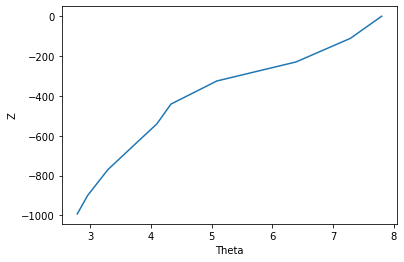

In [17]:
ds_subsamp.Theta.plot(y='Z')

In [3]:
# 4d!?!?!??!?!
# how to implement time? => convert to integer?

# first let's do 3d with 3'd dim as time:

# change time to integer
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size))
X = ds.XC # already  X Y time
Y = ds.YC
T = ds.time.broadcast_like(ds.XC)


ds3 = xr.Dataset(
    coords={'X': (('time', 'j', 'i'), X.values), 'Y': (('time', 'j', 'i'), Y.values), 'T': (('time', 'j', 'i'), T.values)},
    data_vars={'Theta': (('time', 'j', 'i'), ds['Theta'].isel(k=0).values)},
)
ds3


<xarray.Dataset>
Dimensions:  (time: 48, j: 349, i: 192)
Coordinates:
    X        (time, j, i) float32 150.3 150.3 150.3 150.4 ... 154.2 154.3 154.3
    Y        (time, j, i) float32 -56.99 -56.99 -56.99 ... -53.01 -53.01 -53.01
    T        (time, j, i) float64 0.0 0.0 0.0 0.0 0.0 ... 47.0 47.0 47.0 47.0
Dimensions without coordinates: time, j, i
Data variables:
    Theta    (time, j, i) float64 1.959 1.962 1.96 1.949 ... 7.308 7.088 6.977

In [19]:
# trajectory:

# 3d 
tds = xr.open_dataset('../data/survey_trajectory_ACC_SMST_glider.nc')
xs = np.tile(tds.xwaypoints.isel(points=[0]).values,10)
ys = np.tile(tds.ywaypoints.isel(points=[0]).values,10)
ts = np.linspace(ds.time[0], ds.time[-1], 10)


traj = xr.Dataset({
    'X': ('points', xs),
    'Y': ('points',ys),
    'T': ('points',ts)
})

ds3.xoak.set_index(['X', 'Y', 'T'], 'sklearn_balltree')

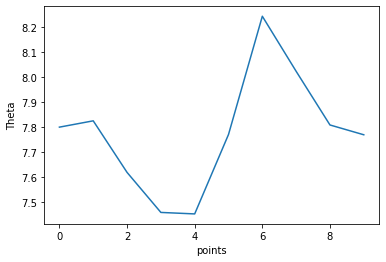

In [20]:
# apply xoak magic:
ds_subsamp = ds3.xoak.sel(
    X=traj.X,
    Y=traj.Y,
    T=traj.T
)

ds_subsamp.Theta.plot()

In [9]:
Theta = ds['Theta'].values

In [17]:
# 4d!

X = ds.XC.broadcast_like(ds.Z)
Y = ds.YC.broadcast_like(ds.Z)
T = ds.time.broadcast_like(X)
Z = ds.Z.broadcast_like(X)

#Error 
# ValueError: dimensions ('time', 'k', 'j', 'i') must have the same length as the number of data dimensions, ndim=2                                                                                             

ds4 = xr.Dataset(
    coords={'X': (('time', 'k', 'j', 'i'), X.values), 'Y': (('time', 'k', 'j', 'i'), Y.values), 
            'T': (('time', 'k', 'j', 'i'), T.values), 'Z': (('time', 'k', 'j', 'i'), Z.values)},
    data_vars={'Theta': (('time', 'k', 'j', 'i'), Theta)},
)
ds4


<xarray.Dataset>
Dimensions:  (time: 48, k: 84, j: 349, i: 192)
Coordinates:
    X        (time, k, j, i) float32 150.3 150.3 150.3 ... 154.2 154.3 154.3
    Y        (time, k, j, i) float32 -56.99 -56.99 -56.99 ... -53.01 -53.01
    T        (time, k, j, i) float64 0.0 0.0 0.0 0.0 0.0 ... 47.0 47.0 47.0 47.0
    Z        (time, k, j, i) float32 -0.5 -0.5 -0.5 ... -4.535e+03 -4.535e+03
Dimensions without coordinates: time, k, j, i
Data variables:
    Theta    (time, k, j, i) float64 1.959 1.962 1.96 1.949 ... nan nan nan nan

In [18]:
# trajectory:

# 4d 
tds = xr.open_dataset('../data/survey_trajectory_ACC_SMST_glider.nc')
xs = np.tile(tds.xwaypoints.isel(points=[0]).values,10)
ys = np.tile(tds.ywaypoints.isel(points=[0]).values,10)
ts = np.linspace(ds.time[0], ds.time[-1], 10)
zs = np.linspace(-1, -1000, 10)


traj = xr.Dataset({
    'X': ('points', xs),
    'Y': ('points',ys),
    'T': ('points',ts),
    'Z': ('points',zs)
})

# this is the slow part:
ds4.xoak.set_index(['X', 'Y', 'T', 'Z'], 'sklearn_balltree')

In [20]:
%%time
# apply xoak magic:
ds_subsamp = ds4.xoak.sel(
    X=traj.X,
    Y=traj.Y,
    T=traj.T,
    Z=traj.Z
)

ds_subsamp

CPU times: user 118 ms, sys: 3.93 ms, total: 122 ms
Wall time: 163 ms


<xarray.Dataset>
Dimensions:  (points: 10)
Coordinates:
    X        (points) float32 151.7 151.8 151.8 151.7 ... 151.7 151.8 151.7
    Y        (points) float32 -55.0 -55.0 -55.0 -55.0 ... -55.0 -55.0 -55.0
    T        (points) float64 0.0 5.0 10.0 16.0 21.0 26.0 31.0 37.0 42.0 47.0
    Z        (points) float32 -0.5 -111.6 -229.9 -325.3 ... -770.6 -900.1 -992.3
Dimensions without coordinates: points
Data variables:
    Theta    (points) float64 7.796 7.228 6.493 5.236 ... 3.44 3.145 2.839 2.542

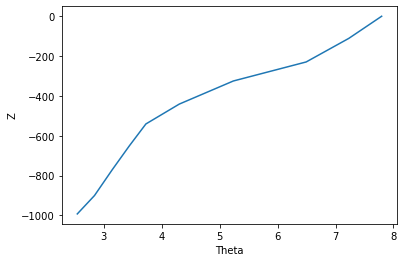

In [23]:
ds_subsamp.Theta.plot(y='Z')

In [26]:
%%time
# with dask
import dask
from dask.diagnostics import ProgressBar

with ProgressBar(), dask.config.set(scheduler='processes'):
    ds_subsamp = ds4.xoak.sel(
        X=traj.X,
        Y=traj.Y,
        T=traj.T,
        Z=traj.Z
    )

ds_subsamp



CPU times: user 123 ms, sys: 103 µs, total: 123 ms
Wall time: 123 ms


<xarray.Dataset>
Dimensions:  (points: 10)
Coordinates:
    X        (points) float32 151.7 151.8 151.8 151.7 ... 151.7 151.8 151.7
    Y        (points) float32 -55.0 -55.0 -55.0 -55.0 ... -55.0 -55.0 -55.0
    T        (points) float64 0.0 5.0 10.0 16.0 21.0 26.0 31.0 37.0 42.0 47.0
    Z        (points) float32 -0.5 -111.6 -229.9 -325.3 ... -770.6 -900.1 -992.3
Dimensions without coordinates: points
Data variables:
    Theta    (points) float64 7.796 7.228 6.493 5.236 ... 3.44 3.145 2.839 2.542

In [43]:
## that works! let's try a more complicated trajectory...
survey_track = xr.open_dataset('./survey_track_test.nc')
survey_track.time

# change time to integer - 
date64 = survey_track.time  # in datetime64 format
# converting date time into second timestamp 
ts = (date64 - date64[0]) / np.timedelta64(1, 'h')
ts

survey_track = survey_track.assign_coords(time=ts)
survey_track.time

<xarray.DataArray 'time' (points: 15984)>
array([0.00000000e+00, 2.77777778e-03, 5.55555556e-03, ...,
       4.43916667e+01, 4.43944444e+01, 4.43972222e+01])
Coordinates:
    time     (points) float64 0.0 0.002778 0.005556 ... 44.39 44.39 44.4
Dimensions without coordinates: points

In [ ]:
# traj = xr.Dataset({
#     'X': ('points', xs),
#     'Y': ('points',ys),
#     'T': ('points',ts),
#     'Z': ('points',zs)
# })

# # this is the slow part:
# ds4.xoak.set_index(['X', 'Y', 'T', 'Z'], 'sklearn_balltree')

In [44]:
with ProgressBar(), dask.config.set(scheduler='processes'):
    ds_subsamp = ds4.xoak.sel(
        X=survey_track.lon,
        Y=survey_track.lat,
        T=survey_track.time,
        Z=survey_track.dep
    )

ds_subsamp



<xarray.Dataset>
Dimensions:  (points: 15984)
Coordinates:
    X        (points) float32 151.3 151.3 151.3 151.3 ... 151.3 151.3 151.3
    Y        (points) float32 -55.99 -55.99 -55.99 ... -55.63 -55.63 -55.63
    T        (points) float64 0.0 0.0 0.0 0.0 0.0 ... 44.0 44.0 44.0 44.0 44.0
    Z        (points) float32 -0.5 -1.57 -2.79 -4.185 ... -2.79 -1.57 -0.5
Dimensions without coordinates: points
Data variables:
    Theta    (points) float64 1.861 1.854 1.849 1.845 ... 5.534 5.537 5.538

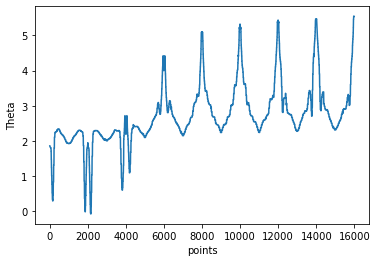

In [46]:
ds_subsamp.Theta.plot()
# !! yes, this looks the same as doing it with my code
# - but is it faster ???
# - need to reshape to really test - that's the slow part


In [ ]:
# also, can we try *not* creating a new dataset and instead modifying ds to be useable by xoak?
